In [1]:
import utils
import models
import numpy as np
import torch
import configs
import pgm_explainer as pe
from scipy.special import softmax
import pandas as pd
from pgmpy.estimators.CITests import chi_square
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination
from tqdm import tqdm
import argparse
import math
    
def arg_parse():
    parser = argparse.ArgumentParser(description="Explainer arguments.")

    parser.add_argument(
            "--bmname", dest="bmname", help="Name of the benchmark dataset"
        )
    parser.add_argument("--dataset", dest="dataset", help="Input dataset.")
    parser.add_argument("--ckptdir", dest="ckptdir", help="Model checkpoint directory")
    parser.add_argument(
            "--gpu",
            dest="gpu",
            action="store_const",
            const=True,
            default=False,
            help="whether to use GPU.",
        )
    parser.add_argument(
            "--node-start", dest="node_start", type=int, help="Index of starting node."
        )
    parser.add_argument(
            "--node-end", dest="node_end", type=int, help="Index of ending node."
        )
    parser.add_argument(
            "--num-perturb-samples", dest="num_perturb_samples", type=int, help="Number of perturbed sample using to generate explanations."
        )
    parser.add_argument(
            "--top-node", dest="top_node", type=int, help="Number of nodes in explanation."
        )
    parser.add_argument(
            "--epochs", dest="num_epochs", type=int, help="Number of epochs to train."
        )
    parser.add_argument(
            "--hidden-dim", dest="hidden_dim", type=int, help="Hidden dimension"
        )
    parser.add_argument(
            "--output-dim", dest="output_dim", type=int, help="Output dimension"
        )
    parser.add_argument(
            "--num-gc-layers",
            dest="num_gc_layers",
            type=int,
            help="Number of graph convolution layers before each pooling",
        )
    parser.add_argument(
            "--bn",
            dest="bn",
            action="store_const",
            const=True,
            default=False,
            help="Whether batch normalization is used",
        )
    parser.add_argument("--dropout", dest="dropout", type=float, help="Dropout rate.")
    parser.add_argument(
            "--method", dest="method", type=str, help="Method. Possible values: base, att."
        )
    parser.add_argument(
            "--nobias",
            dest="bias",
            action="store_const",
            const=False,
            default=True,
            help="Whether to add bias. Default to True.",
        )
    
        # Explainer
   
    

    parser.set_defaults(
            ckptdir=None,
            dataset="syn1",
            opt="adam",  
            opt_scheduler="none",
            lr=0.1,
            clip=2.0,
            batch_size=20,
            num_epochs=100,
            hidden_dim=20,
            output_dim=20,
            num_gc_layers=3,
            method="base",
            dropout=0.0,
            node_start = None,
            node_end = None,
            num_perturb_samples = 100,
            top_node = None
        )
    
    return parser

d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
prog_args = arg_parse()
args= prog_args.parse_args(['--dataset','syn2','--num-perturb-samples', '900','--top-node', '3'])

In [3]:
# Load model
A, X = utils.load_XA(args.dataset, datadir = "../Generate_XA_Data/XAL")
L = utils.load_labels(args.dataset, datadir = "../Generate_XA_Data/XAL")
num_classes = max(L) + 1
input_dim = X.shape[1]
num_nodes = X.shape[0]
ckpt = utils.load_ckpt(args)

print("input dim: ", input_dim, "; num classes: ", num_classes)
    
model = models.GcnEncoderNode(
        input_dim=input_dim,
        hidden_dim=args.hidden_dim,
        embedding_dim=args.output_dim,
        label_dim=num_classes,
        num_layers=args.num_gc_layers,
        bn=args.bn,
        args=args,
        )
model.load_state_dict(ckpt["model_state"]) 
pred = ckpt["save_data"]["pred"]

loading model
../Train_GNN_model/ckpt\syn2.pth.tar
=> loading checkpoint '../Train_GNN_model/ckpt\syn2.pth.tar'
input dim:  10 ; num classes:  8


In [4]:
import random
random.seed(21)

In [5]:
# Range of node to explain in this dataset is from 300 to 700
nodes_to_explain = list(range(400,700,5)) 

In [6]:
# Construct the explainer
explainer = pe.Node_Explainer(model, A, X, pred, 3)

Explainer settings
\ A dim:  (1400, 1400)
\ X dim:  (1400, 10)
\ Number of layers:  3
\ Perturbation mode:  0
\ Print result:  1


In [7]:
import networkx as nx
import pylab as plt

def pgm_draw_nx(pgm_explanation):
    print("Draw pgm explaination using networkx")
    nx.draw(pgm_explanation, with_labels=True)
    plt.show()

def PGM_construct(pgm_explanation, target_name):
    loc = [(0, 0), (-5, -5), (5, -5), (5, 5), (-5,5)]
    pos = dict(zip(pgm_explanation.nodes(), loc))
    color_dict = dict(zip(range(pred.shape[2]), ['y','b','m','r']))
    color = [color_dict[ np.argmax(pred[0,int(node),:])] for node in pgm_explanation.nodes()]
    name_dict = [r'$A$',r'$B$',r'$C$',r'$D$',r'$E$']
    name = dict(zip(pgm_explanation.nodes(), name_dict))

    # gt_graph = nx.Graph()
    # gt_graph.add_nodes_from(pos.keys(), size=50)
    # edges_list = [('300', '301'),('301', '302'),('302', '300'),('303', '300'),('304', '300')]
    # gt_graph.add_edges_from(edges_list)

    # print("Ground truth explaination of node ", name[target_name])
    # figure1, ax1 = plt.subplots(figsize = (4,4))
    # ax1.axis('off')
    # nx.draw_networkx_nodes(gt_graph,pos,node_size=400,node_color= color)
    # nx.draw_networkx_edges(gt_graph,pos,
    #                     edgelist= edges_list,
    #                     width=2.0,alpha=1)
    # nx.draw_networkx_labels(gt_graph,pos,name,font_size=18, font_family = 'serif', font_weight = 'normal',
    #                         font_color = 'w')

    # # filename = 'view/motif_' + str(explained_node)+ '.jpg' 
    # # figure1.savefig(filename, dpi=90, bbox_inches='tight')

    print("PGM explaination of node ", name[target_name])

    figure2, ax = plt.subplots(figsize = (4,4))
    ax.axis('off')
    nx.draw_networkx_nodes(pgm_explanation,pos,node_size=400,node_color= color)
    nx.draw_networkx_edges(pgm_explanation,pos,
                        edgelist= pgm_explanation.edges,
                        connectionstyle='arc3, rad = 0.2',
                        width=2.0,alpha=0.8)
    nx.draw_networkx_labels(pgm_explanation,pos,name,font_size=18, font_family = 'serif', font_color = 'w')
    figure2.show()

    # filename = 'view/pgm_' + str(explained_node)+ '.jpg' 
    # figure2.savefig(filename, dpi=90, bbox_inches='tight')



In [8]:
# Functions to analyze the graph properties
def betweeness_centrality_single_sink(graph,node_to_explain, v):
    
    bc = 0
    diameter = nx.diameter(graph)
    nodes = list(graph.nodes())
    for i in tqdm(range(len(nodes))):
        paths_with_v = 0
        paths = 0
        if nodes[i]!=node_to_explain and nodes[i]!=v:
            # print(f"Centrality of {v} chosen node {i}")
            if nx.has_path(graph,nodes[i],node_to_explain):
                # Find all paths between i and the node_to_explain
                all_paths = nx.all_simple_paths(graph,nodes[i],node_to_explain,diameter)
                # print("All paths obtained")

                # Find the paths containing v
                for path in all_paths:
                    # print("loop entered")
                    # print(paths)
                    paths += 1
                    if v in path:
                        paths_with_v += 1

                # Add this to bc
                bc += paths_with_v/paths
    
    return bc

def normalize(A):
    scale_factor = A.max() - A.min()
    B = np.ones_like(A)*A.min()

    A = (A - B)/scale_factor
    return A

def centrality(G, stats,node_to_explain,p_threshold=0.05):

    sources = [node_to_explain]
    targets = [v for v in list(G.nodes()) if v!=node_to_explain]
    bc = nx.betweenness_centrality_subset(G,sources,targets)
    
    
    # Node coherence
    # Get the two vectors we have to compare for coherence calculation
    # We are fixing the values as 0 for the nodes not in "nodes_to_consider"
    A = []
    B = []
    for i in list(G.nodes()):
        A.append(bc.get(i))
        B.append(1 - (stats.get(i)))

    A = normalize(np.array(A))
    B = normalize(np.array(B))

    # Calculating coherence
    a = (np.linalg.norm(A - B,2)**2)

    coh = 2/(1 + math.exp(a))
    # if(np.array_equal(A,B) == False):
    #     coh = 1/(np.linalg.norm(A - B,2))**2
    # else:
    #     coh = 1
    
    return coh

def graph_prop(graph, stats, target, p_threshold):
    v = graph.number_of_nodes()
    e = graph.number_of_edges()
    avg_degree = float('%.3f'%(2*e/v))
    diameter = nx.diameter(graph)
    sparsity = float('%.3f'%(1 - (2*e/(v*(v-1)))))
    coh = centrality(graph,stats, target, p_threshold)

    return [v,e,avg_degree,diameter,sparsity,coh]

In [9]:
# Check the node mask obtained
# "stats" has the n-hop neighbors of the target node and the corresponding p-values
# The dependent neighbors are chosen based on comparing the p-value to a certain threshold
# For this reason we use the p-values as an indicator of importance of the node
# We define node_importance_by_exp = (1-p)

graph_data = []

# Explaining each target node
for target in nodes_to_explain:
    # Explaining the target node
    p_threshold = 0.05  # Default threshold for p-value according to statistics

    # We set top_node as None since we want to check how compact the explanations are without restricting its size
    _, _, stats = explainer.explain(target, num_samples = 900, p_threshold=p_threshold, pred_threshold = 0.2)

    # Original network
    G = nx.from_numpy_array(explainer.A)
    # Considered neighbors
    nbors = list(stats.keys())
    # nodes_to_consider = []
    # # Masking the nodes
    # for v in nbors:
    #     if stats.get(v) < p_threshold:
    #         nodes_to_consider.append(v)

    # Vertex induced subgraph that acts as the explanation
    exp_subgraph = nx.induced_subgraph(G, nbors)

    # All properties obtained
    graph_data.append(graph_prop(exp_subgraph,stats, target, p_threshold))

# Convert the above data into a data frame
df1 = pd.DataFrame(graph_data, columns=["Order","Size","Average Degree","Diameter","Sparsity","Coherence"])

df1.describe()

Explaining node: 400


d:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\PGM_Node\Explain_GNN\pgm_explainer.py:121: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  A_torch = torch.tensor([self.A], dtype=torch.float)


Explaining node: 405
Explaining node: 410
Explaining node: 415
Explaining node: 420
Explaining node: 425
Explaining node: 430
Explaining node: 435
Explaining node: 440
Explaining node: 445
Explaining node: 450
Explaining node: 455
Explaining node: 460
Explaining node: 465
Explaining node: 470
Explaining node: 475
Explaining node: 480
Explaining node: 485
Explaining node: 490
Explaining node: 495
Explaining node: 500
Explaining node: 505
Explaining node: 510
Explaining node: 515
Explaining node: 520
Explaining node: 525
Explaining node: 530
Explaining node: 535
Explaining node: 540
Explaining node: 545
Explaining node: 550
Explaining node: 555
Explaining node: 560
Explaining node: 565
Explaining node: 570
Explaining node: 575
Explaining node: 580
Explaining node: 585
Explaining node: 590
Explaining node: 595
Explaining node: 600
Explaining node: 605
Explaining node: 610
Explaining node: 615
Explaining node: 620
Explaining node: 625
Explaining node: 630
Explaining node: 635
Explaining no

,Order,Size,Average Degree,Diameter,Sparsity,Coherence
count,60.000000,60.000000,60.000000,60.000000,60.000000,6.000000e+01
mean,171.916667,577.133333,6.381667,5.883333,0.958017,1.404671e-05
std,76.145109,338.908241,1.010656,0.323732,0.012754,6.262801e-05
min,60.000000,138.000000,3.538000,5.000000,0.919000,4.649658e-20
25%,122.250000,347.500000,5.715500,6.000000,0.952750,6.466807e-12
50%,154.500000,501.500000,6.437500,6.000000,0.959000,6.870505e-09
75%,195.250000,694.750000,7.097750,6.000000,0.966250,5.895083e-07
max,416.000000,1704.000000,8.280000,6.000000,0.980000,4.492408e-04


In [14]:
coh = df1['Coherence']

cohh = [x for x in coh if x == 0]
cohh

[]

In [10]:
df1.to_csv("syn2.csv")

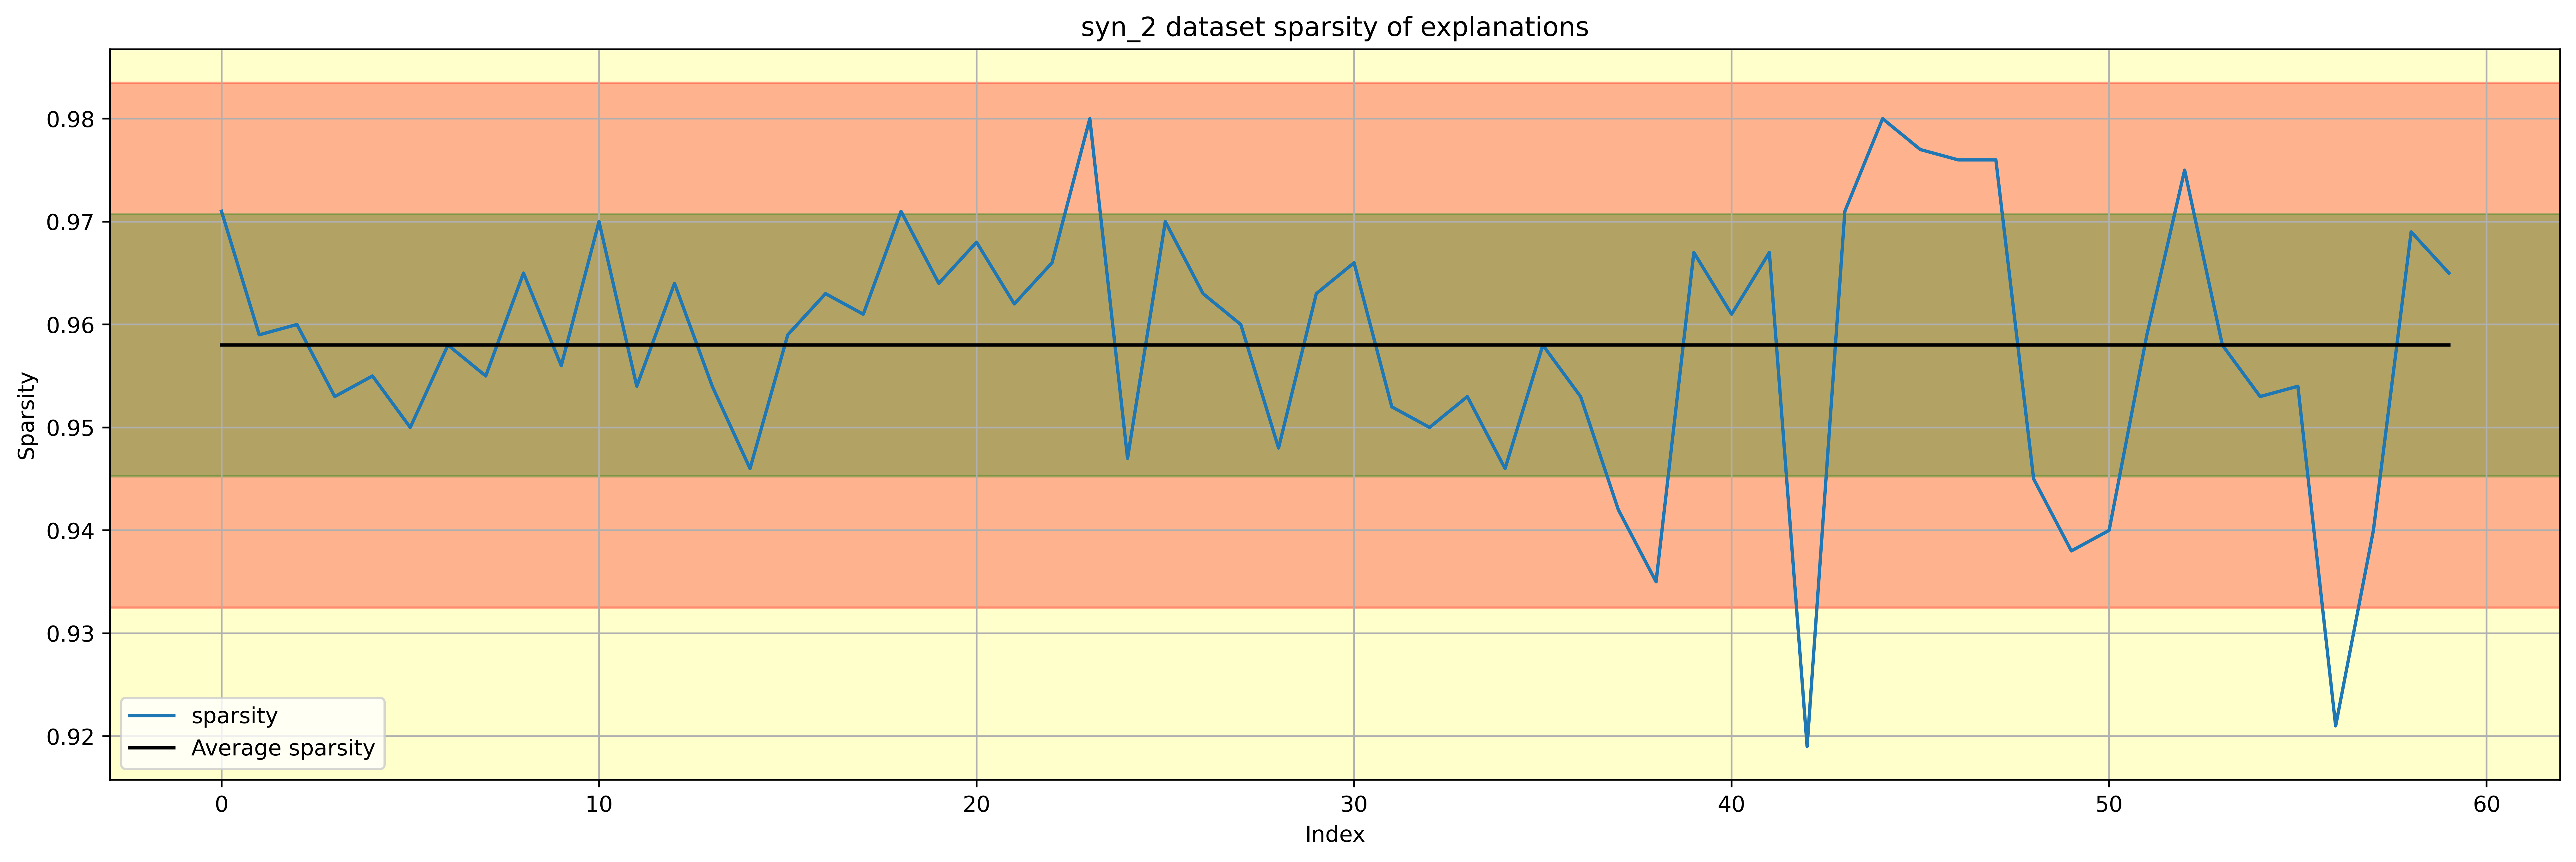

In [11]:
# Plot Sparsity
x = list(range(len(df1)))
sparse = list(df1['Sparsity'])
def_sparse = list(np.ones(len(df1))*0.5)
mean_sparse = list(np.ones(len(df1))*df1['Sparsity'].mean())
plt.figure(figsize=(20,6), dpi = 500)
plt.gca().grid(True)
plt.gca().set_facecolor((1, 1, 0.8))
plt.plot(x, sparse, label='sparsity')
plt.plot(x,mean_sparse, label = 'Average sparsity', color='k')

sp_mean = df1['Sparsity'].mean()
sp_std = df1['Sparsity'].std()
y1 = sp_mean - sp_std
y_1 = y1 - sp_std
y2 = sp_mean + sp_std
y_2 = y2 + sp_std
plt.axhspan(y_1, y_2, color='red', alpha=0.3)
plt.axhspan(y1, y2, color='green', alpha=0.3)

plt.title('syn_2 dataset sparsity of explanations', fontsize=12)
plt.legend(prop={'size':10})
plt.ylabel("Sparsity")
plt.xlabel("Index")
plt.savefig(fname= "D:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\PGM_Node\Explain_GNN\plots\syn2_sparsity")
plt.show()

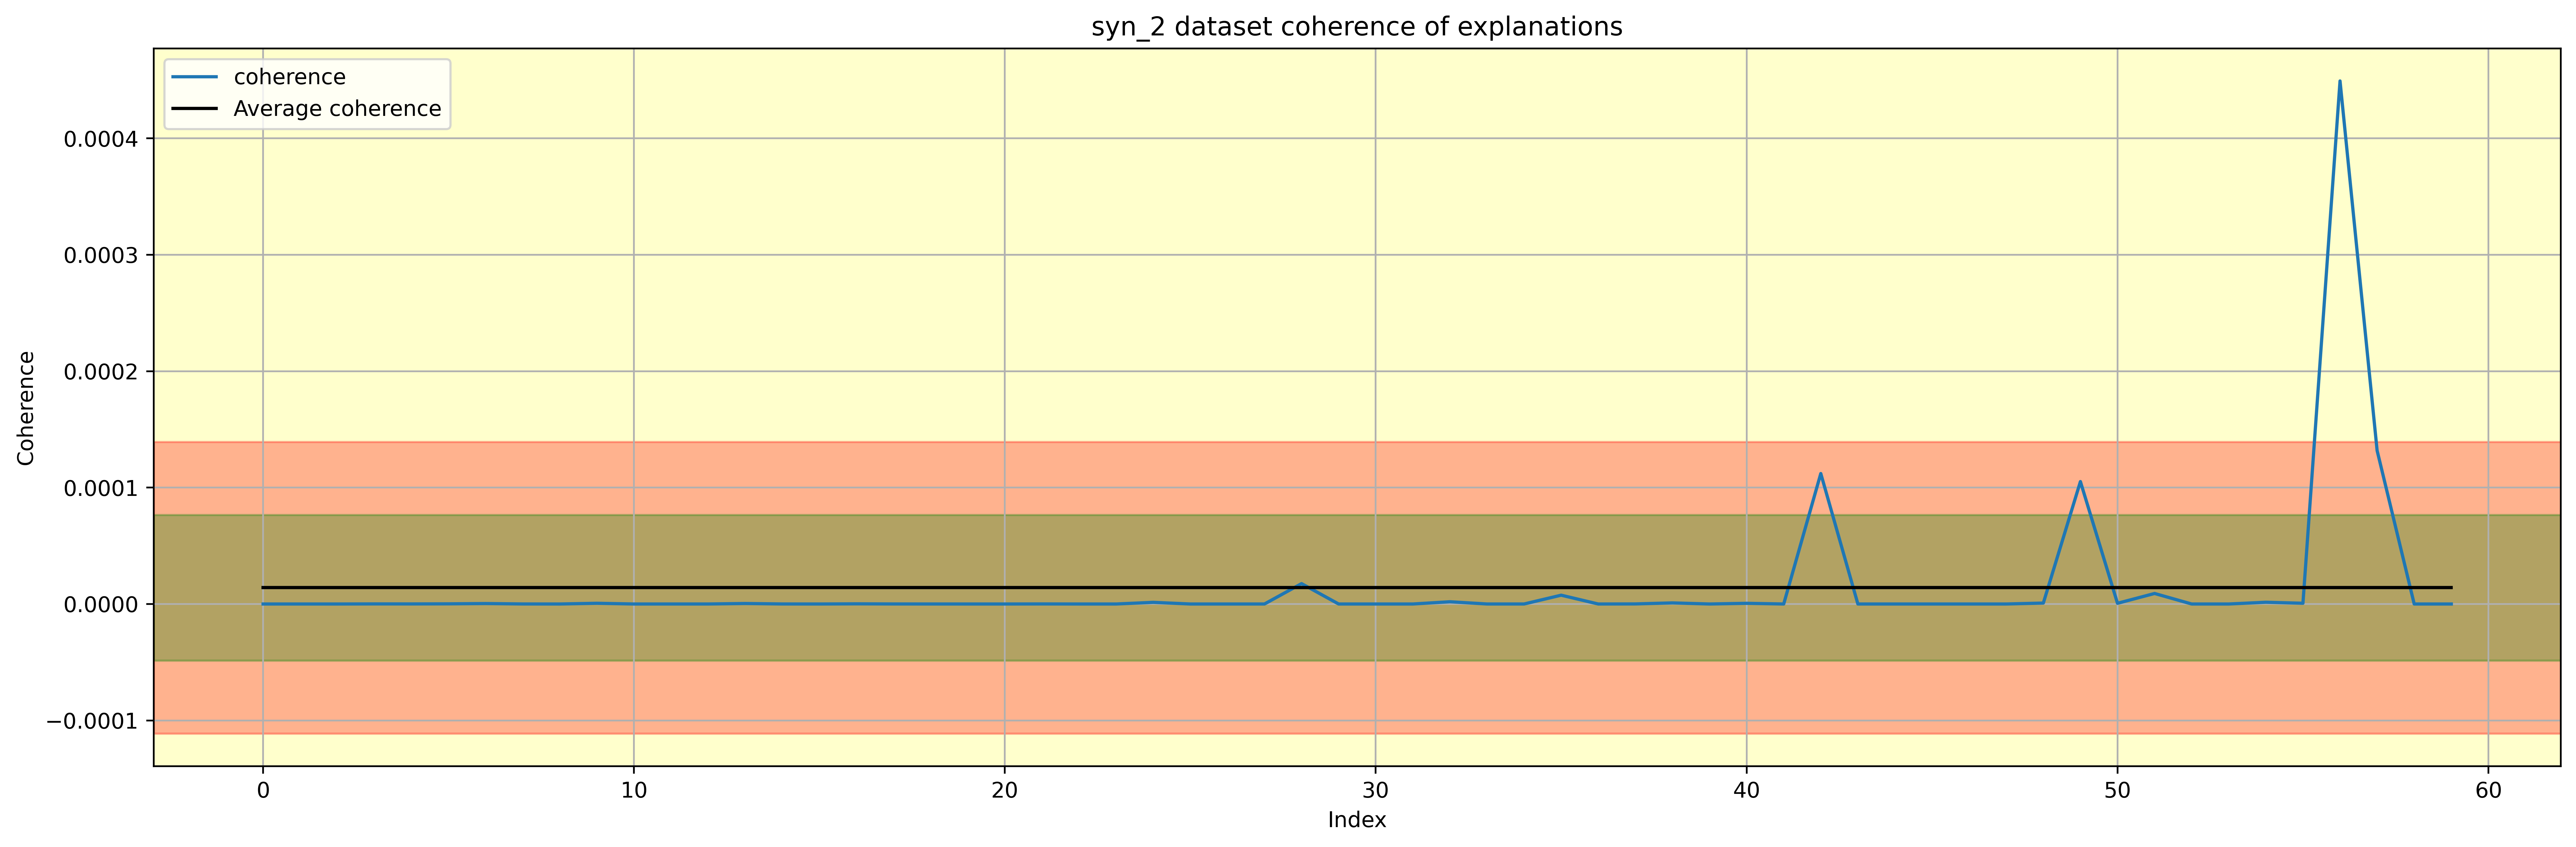

In [12]:
# Plot Coherence
x = list(range(len(df1)))
coh = list(df1['Coherence'])
def_coh = list(np.ones(len(df1))*0.5)
mean_coh = list(np.ones(len(df1))*df1['Coherence'].mean())
plt.figure(figsize=(20,6), dpi = 500)
plt.gca().grid(True)
plt.gca().set_facecolor((1, 1, 0.8))
plt.plot(x, coh, label='coherence')
plt.plot(x,mean_coh, label = 'Average coherence', color='k')

sp_mean = df1['Coherence'].mean()
sp_std = df1['Coherence'].std()
y1 = sp_mean - sp_std
y_1 = y1 - sp_std
y2 = sp_mean + sp_std
y_2 = y2 + sp_std
plt.axhspan(y_1, y_2, color='red', alpha=0.3)
plt.axhspan(y1, y2, color='green', alpha=0.3)

plt.title('syn_2 dataset coherence of explanations', fontsize=12)
plt.legend(prop={'size':10})
plt.ylabel("Coherence")
plt.xlabel("Index")
plt.savefig(fname= "D:\D_Drive\Github\Thesis\PGMExplainer_graph_properties\PGM_Node\Explain_GNN\plots\syn2_coherence")
plt.show()